In [15]:
from tracr.rasp import rasp
from tracr.compiler import compiling
from tracr.compiler import lib

import sys
import os

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.model import Model
from src.functions import *

In [92]:
#Merge the results from the files in list. The files need to have the same dimension
def loadArray(fileNames="temp", mean=True):
    if type(fileNames) is list:
        file = open(fileNames[0], "rb")
        array = np.load(file)
        file.close()
        for fn in fileNames[1:]:
            file = open(fn, "rb")
            conAcc = np.load(file)
            array = np.concatenate((array, conAcc), axis=1)
            file.close()
        
    else:
        file = open(fileNames, "rb")
        array = np.load(file)
        file.close()

    return array

def displayPlot(data, ax, n_epochs, title="", xLabel="", ylabel="", logarithmic = False, legend = False):
    ax.plot(np.linspace(0, n_epochs, len(data)), data)
    if logarithmic:
        ax.set_yscale('log')
    if legend:
        ax.set_label(legend)
        ax.legend()
    ax.set(xlabel=xLabel, ylabel=ylabel)
    ax.set_title(title)

#Assumes models are saved in standard format
def displayResults(baseDirectory, modelName, displayDefault = True, displayRandom = False, consideredVersions = [1,2,3] ,figsize=(14,6), n_epochs = 50000):
    fig, axs = plt.subplots(1,2, figsize=figsize)
    legend = []
    for v in consideredVersions:
        if displayDefault:
            legend.append("Default Weights n="+str(v*5))
            loss = loadArray(baseDirectory + modelName +"_loss_v"+str(v))
            logloss = np.log10(loss+1)
            axs[0].plot(np.linspace(0, n_epochs, len(loss)), logloss)
            val = loadArray(baseDirectory + modelName +"_val_v"+str(v))
            axs[1].plot(np.linspace(0, n_epochs, len(val)), val)

        if displayRandom:
            legend.append("Random Weights n="+str(v*5))
            loss = loadArray(baseDirectory + "random_" + modelName +"_loss_v"+str(v))
            logloss = np.log10(loss+1)
            axs[0].plot(np.linspace(0, n_epochs, len(loss)), logloss)
            val = loadArray(baseDirectory + "random_" + modelName +"_val_v"+str(v))
            axs[1].plot(np.linspace(0, n_epochs, len(val)), val)

    axs[0].set_title("Loss [log(loss+1)]")
    axs[0].set(xlabel="Epochs", ylabel="Logarithmic Loss")
    axs[0].legend(legend)
    axs[1].set_title("Validation Accuracy")
    axs[1].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1].legend(legend)
    fig.suptitle(modelName)

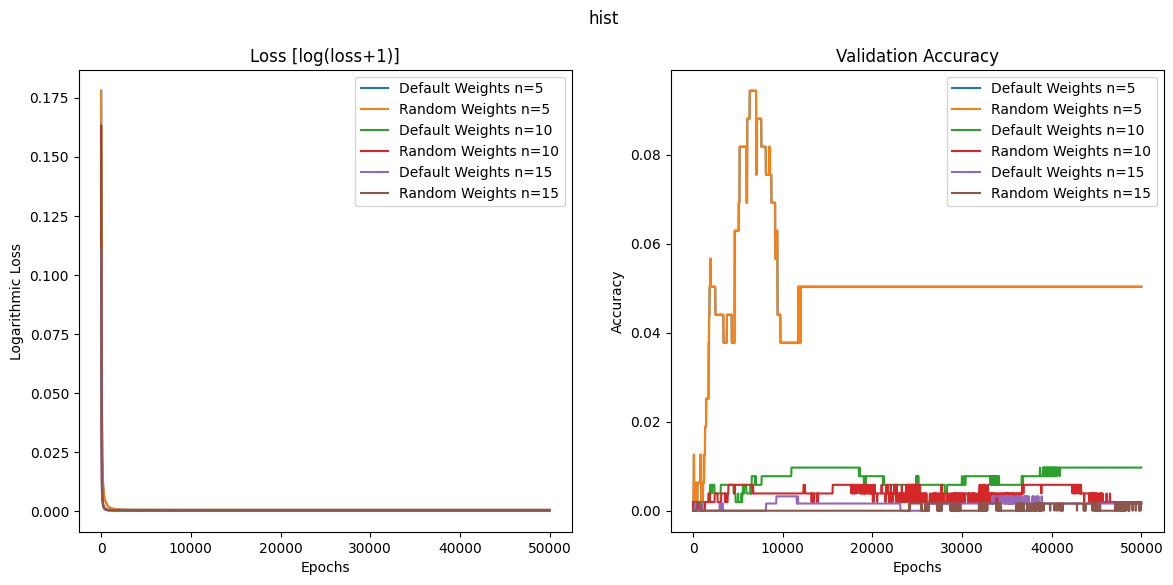

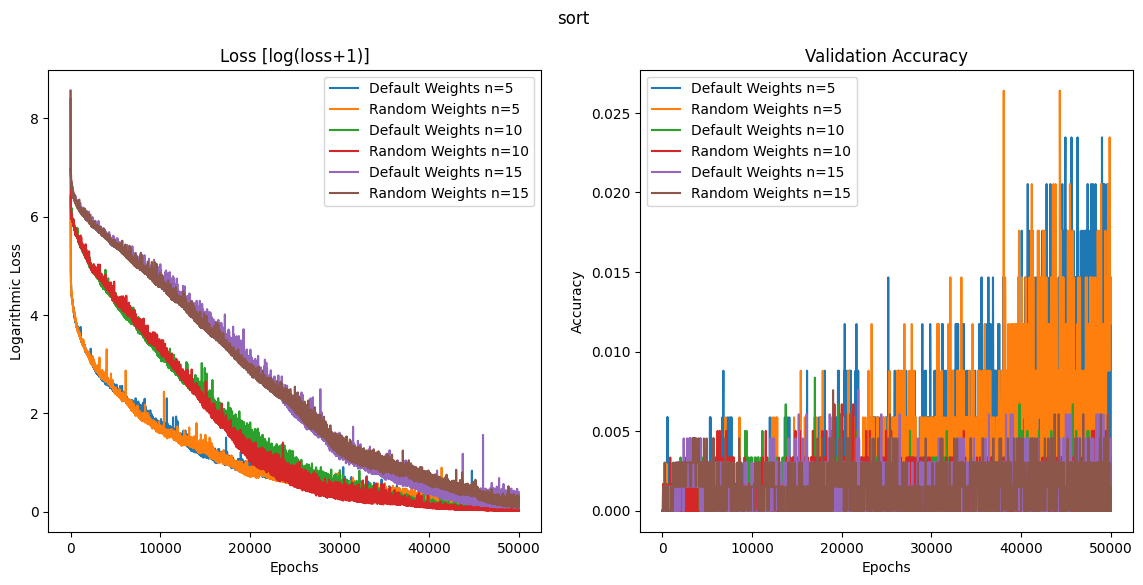

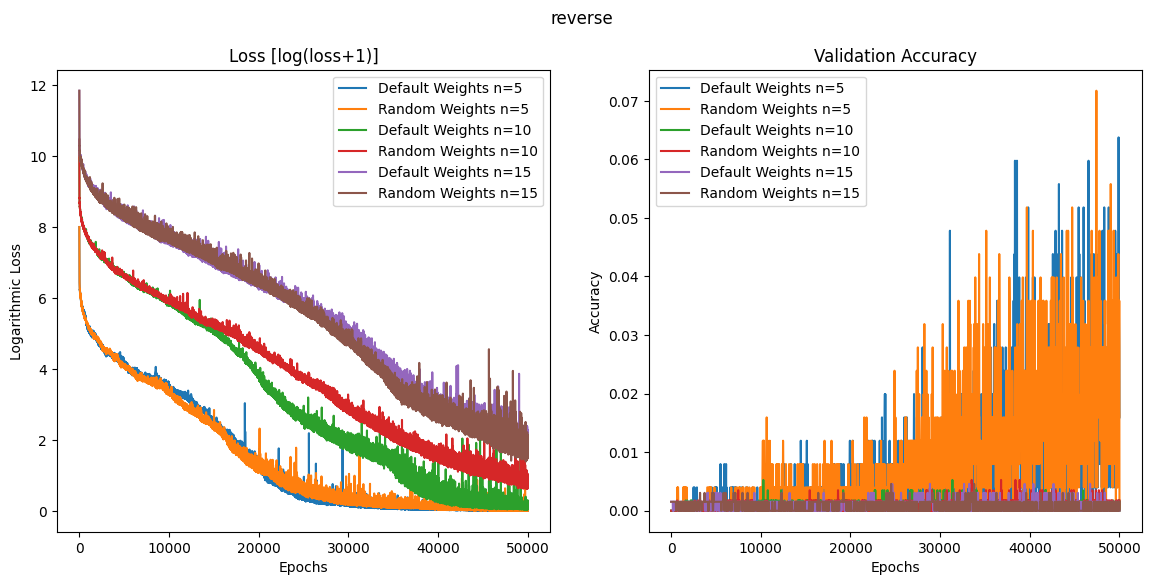

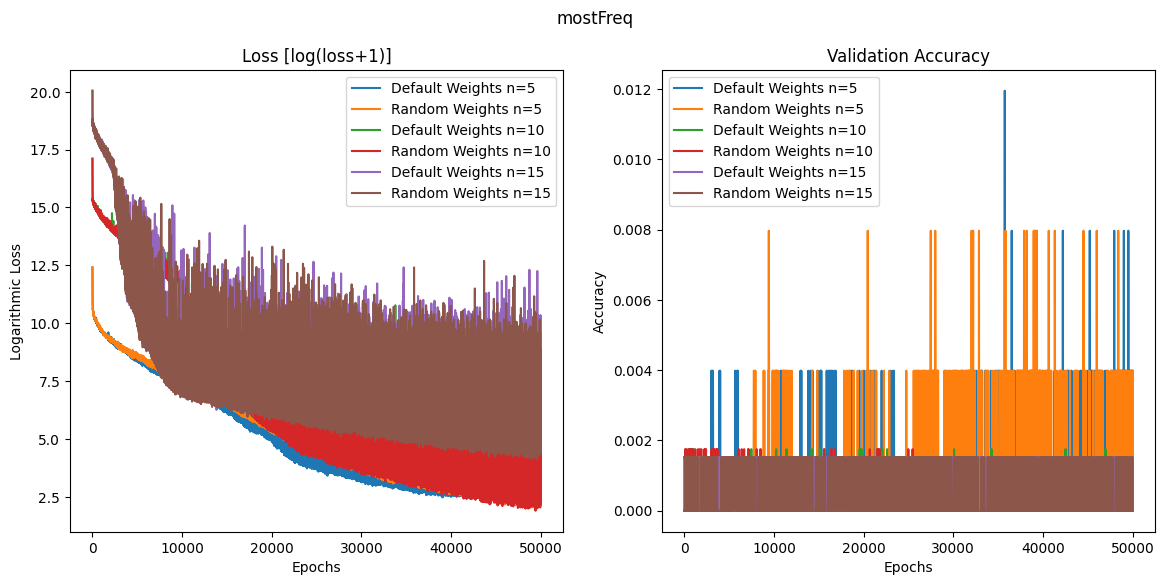

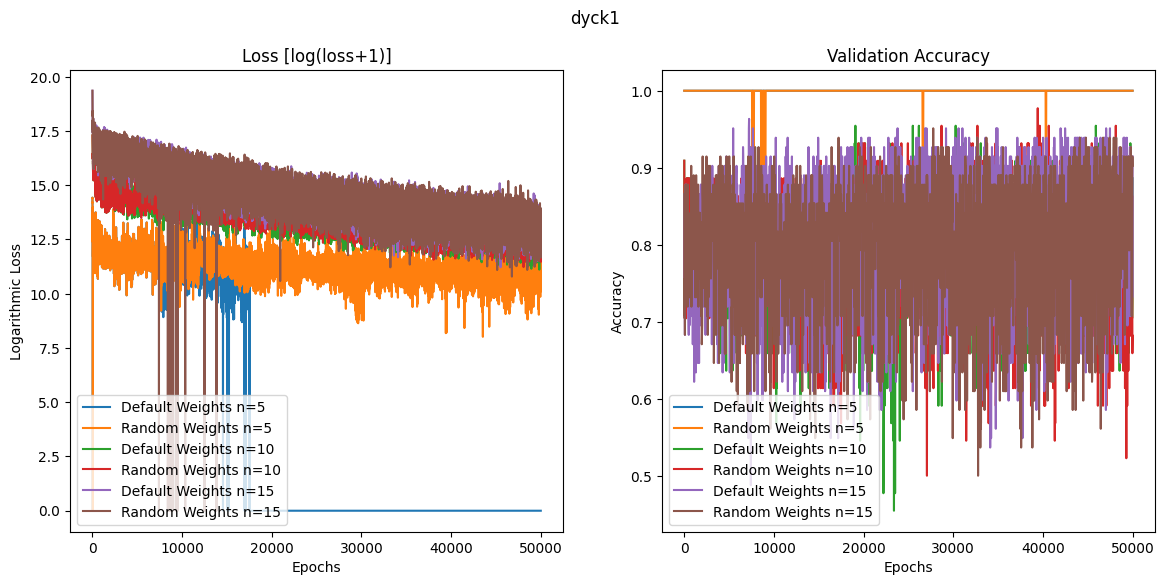

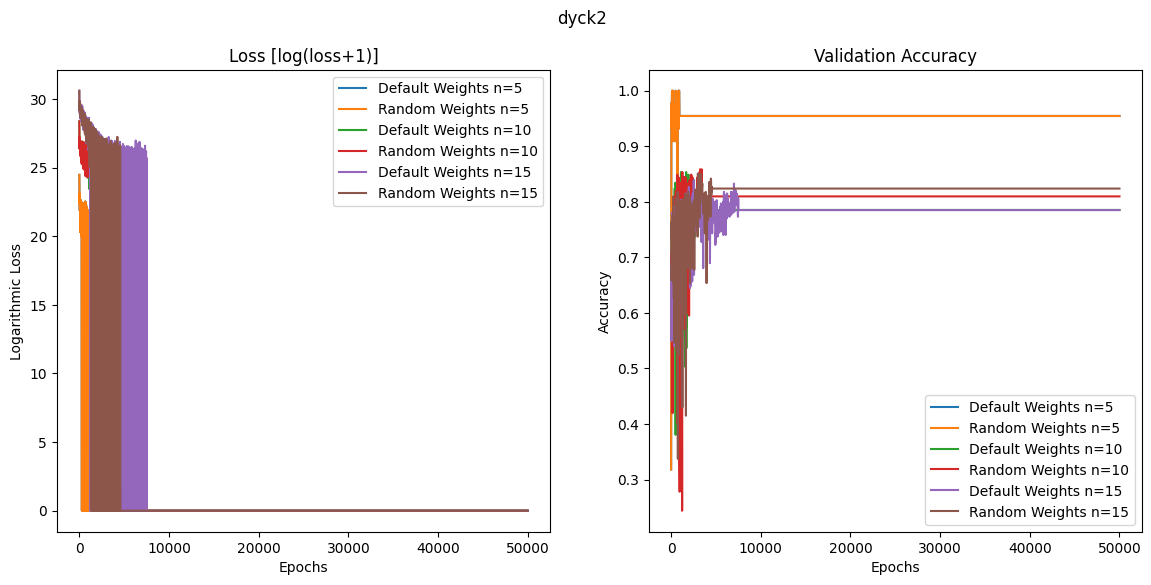

In [93]:
baseDirectory = os.path.abspath(os.path.join('../..')) + "/PerformanceTesting/savedData/finalOvertraining/overTraining/"
displayResults(baseDirectory, "hist", displayRandom=True)
displayResults(baseDirectory, "sort", displayRandom=True)
displayResults(baseDirectory, "reverse", displayRandom=True)
displayResults(baseDirectory, "mostFreq", displayRandom=True)
displayResults(baseDirectory, "dyck1", displayRandom=True)
displayResults(baseDirectory, "dyck2", displayRandom=True)

In [62]:
data = np.ndarray(0)
print(data)
data = np.concat([data.reshape(-1, len(data)), np.arange(5).reshape(1,5)], axis=-1).reshape(-1, 5)
print(data)
data = np.concat([data, np.arange(5).reshape(1,5)], axis=-1).reshape(-1, 5)
print(data, data.shape)

[]


ValueError: cannot reshape array of size 0 into shape (0)

# Display all the results from overtraining

In [95]:
import sys
import os
import numpy as np
import jax.numpy as jnp

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.model import Model
from src.functions import *

#Sloppy code in order to not have to redo entire script
class Args():
    def __init__(self):
        pass
args = Args()

class Parser:
    def __init__(self, args):
        self.args= args

    def add_argument(self, argument, type, default):
        setattr(self.args, argument[1:], default)

parser = Parser(args)

#Argument parsing
parser.add_argument("-baseModel", type=str, default="sort")
parser.add_argument("-maxLength", type=int, default=10)
parser.add_argument("-dataSize", type=int, default=5000)
parser.add_argument("-seed", type=int, default=666)

parser.add_argument("-noiseType", type=str, default="none")
parser.add_argument("-noiseAmount", type=int, default=1)
parser.add_argument("-noiseParam", type=float, default=0.1)

parser.add_argument("-randomWeights", type=bool, default=False)
parser.add_argument("-n_epochs", type=int, default=5000)
parser.add_argument("-batch_size", type=int, default=256)
parser.add_argument("-lr", type=float, default=1e-4)
parser.add_argument("-valStep", type=int, default=50)

parser.add_argument("-saveDirectory", type=str, default="tempData/")
parser.add_argument("-lossFileName", type=str, default="sort_loss_v2")
parser.add_argument("-valFileName", type=str, default="sort_val_v2")

#args = parser.parse_args()

print("Test run with arguments")
print("baseModel:", args.baseModel)
print("maxLength:", args.maxLength)
print("dataSize:", args.dataSize)
print("seed:", args.seed)

print("noiseType:", args.noiseType)
print("noiseAmount:", args.noiseAmount)
print("noiseParam:", args.noiseParam)

print("randomWeights:", args.randomWeights)
print("n_epochs:", args.n_epochs)
print("batch_size:", args.batch_size)
print("lr:", args.lr)
print("valStep:", args.valStep)

print("saveDirectory:", args.saveDirectory)
print("lossFileName:", args.lossFileName)
print("valFileName:", args.valFileName)

#Set up model and data
maxLength = args.maxLength
name = args.baseModel
N = args.dataSize

model = generateModel(name, maxLength)

model.setJaxPRNGKey(args.seed)
np.random.seed(args.seed)

data = generateData(name, maxLength, N, args.randomWeights)
split = int(len(data) * 0.85)
data_train, data_val = data[:split], data[split:]
X, Y = encodeAndPadData(data, model.raspFunction, model.inputs, maxLength)

#Split data
split = int(X.shape[0] * 0.85)
X_train, X_val = X[:split], X[split:]
Y_train, Y_val = Y[:split], Y[split:]

print("\n")
print("X shape: train", X_train.shape, ", val", X_val.shape)
print("Y shape: train", Y_train.shape, ", val", Y_val.shape)
print("Total unique samples", len(data))

noiseTypes = ["bitFlip", "gaussian", "flipFirst"]

#Train model
if args.randomWeights:
    model.setRandomWeights()
if args.noiseType in noiseTypes:
    model.addNoise(args.noiseType, args.noiseAmount, args.noiseParam)
metrics, validations = model.train(X_train, Y_train, n_epochs=args.n_epochs, batch_size=args.batch_size, lr=args.lr, plot=False, X_val=X_val, Y_val=Y_val, valStep=args.valStep)

#Save loss and validation accuracy
def saveArray(array, fileName="temp"):
    file = open(fileName, "wb")
    np.save(file, array)
    file.close()

saveDirectory = args.saveDirectory
saveArray([m["loss"] for m in metrics], saveDirectory + args.lossFileName)
saveArray(validations, saveDirectory + args.valFileName)

Test run with arguments
baseModel: sort
maxLength: 10
dataSize: 5000
seed: 666
noiseType: none
noiseAmount: 1
noiseParam: 0.1
randomWeights: False
n_epochs: 5000
batch_size: 256
lr: 0.0001
valStep: 50
saveDirectory: tempData/
lossFileName: sort_loss_v2
valFileName: sort_val_v2


X shape: train (4250, 11) , val (750, 11)
Y shape: train (4250, 11) , val (750, 11)
Total unique samples 5000


100%|██████████| 5000/5000 [2:03:37<00:00,  1.48s/it]  


In [96]:
import sys
import os
import numpy as np
import jax.numpy as jnp

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.model import Model
from src.functions import *

#Sloppy code in order to not have to redo entire script
class Args():
    def __init__(self):
        pass
args = Args()

class Parser:
    def __init__(self, args):
        self.args= args

    def add_argument(self, argument, type, default):
        setattr(self.args, argument[1:], default)

parser = Parser(args)

#Argument parsing
parser.add_argument("-baseModel", type=str, default="sort")
parser.add_argument("-maxLength", type=int, default=10)
parser.add_argument("-dataSize", type=int, default=5000)
parser.add_argument("-seed", type=int, default=666)

parser.add_argument("-noiseType", type=str, default="none")
parser.add_argument("-noiseAmount", type=int, default=1)
parser.add_argument("-noiseParam", type=float, default=0.1)

parser.add_argument("-randomWeights", type=bool, default=False)
parser.add_argument("-n_epochs", type=int, default=5000)
parser.add_argument("-batch_size", type=int, default=256)
parser.add_argument("-lr", type=float, default=1e-4)
parser.add_argument("-valStep", type=int, default=50)

parser.add_argument("-saveDirectory", type=str, default="tempData/")
parser.add_argument("-lossFileName", type=str, default="sort_loss_v2")
parser.add_argument("-valFileName", type=str, default="sort_val_v2")

#args = parser.parse_args()
################
args.randomWeights = True
args.lossFileName = "random_sort_loss_v2"
args.valFileName = "random_sort_val_v2"


print("Test run with arguments")
print("baseModel:", args.baseModel)
print("maxLength:", args.maxLength)
print("dataSize:", args.dataSize)
print("seed:", args.seed)

print("noiseType:", args.noiseType)
print("noiseAmount:", args.noiseAmount)
print("noiseParam:", args.noiseParam)

print("randomWeights:", args.randomWeights)
print("n_epochs:", args.n_epochs)
print("batch_size:", args.batch_size)
print("lr:", args.lr)
print("valStep:", args.valStep)

print("saveDirectory:", args.saveDirectory)
print("lossFileName:", args.lossFileName)
print("valFileName:", args.valFileName)

#Set up model and data
maxLength = args.maxLength
name = args.baseModel
N = args.dataSize

model = generateModel(name, maxLength)

model.setJaxPRNGKey(args.seed)
np.random.seed(args.seed)

data = generateData(name, maxLength, N, args.randomWeights)
split = int(len(data) * 0.85)
data_train, data_val = data[:split], data[split:]
X, Y = encodeAndPadData(data, model.raspFunction, model.inputs, maxLength)

#Split data
split = int(X.shape[0] * 0.85)
X_train, X_val = X[:split], X[split:]
Y_train, Y_val = Y[:split], Y[split:]

print("\n")
print("X shape: train", X_train.shape, ", val", X_val.shape)
print("Y shape: train", Y_train.shape, ", val", Y_val.shape)
print("Total unique samples", len(data))

noiseTypes = ["bitFlip", "gaussian", "flipFirst"]

#Train model
if args.randomWeights:
    model.setRandomWeights()
if args.noiseType in noiseTypes:
    model.addNoise(args.noiseType, args.noiseAmount, args.noiseParam)
metrics, validations = model.train(X_train, Y_train, n_epochs=args.n_epochs, batch_size=args.batch_size, lr=args.lr, plot=False, X_val=X_val, Y_val=Y_val, valStep=args.valStep)

#Save loss and validation accuracy
def saveArray(array, fileName="temp"):
    file = open(fileName, "wb")
    np.save(file, array)
    file.close()

saveDirectory = args.saveDirectory
saveArray([m["loss"] for m in metrics], saveDirectory + args.lossFileName)
saveArray(validations, saveDirectory + args.valFileName)

Test run with arguments
baseModel: sort
maxLength: 10
dataSize: 5000
seed: 666
noiseType: none
noiseAmount: 1
noiseParam: 0.1
randomWeights: True
n_epochs: 5000
batch_size: 256
lr: 0.0001
valStep: 50
saveDirectory: tempData/
lossFileName: random_sort_loss_v2
valFileName: random_sort_val_v2


X shape: train (3383, 11) , val (598, 11)
Y shape: train (3383, 11) , val (598, 11)
Total unique samples 3981


100%|██████████| 5000/5000 [1:41:59<00:00,  1.22s/it]


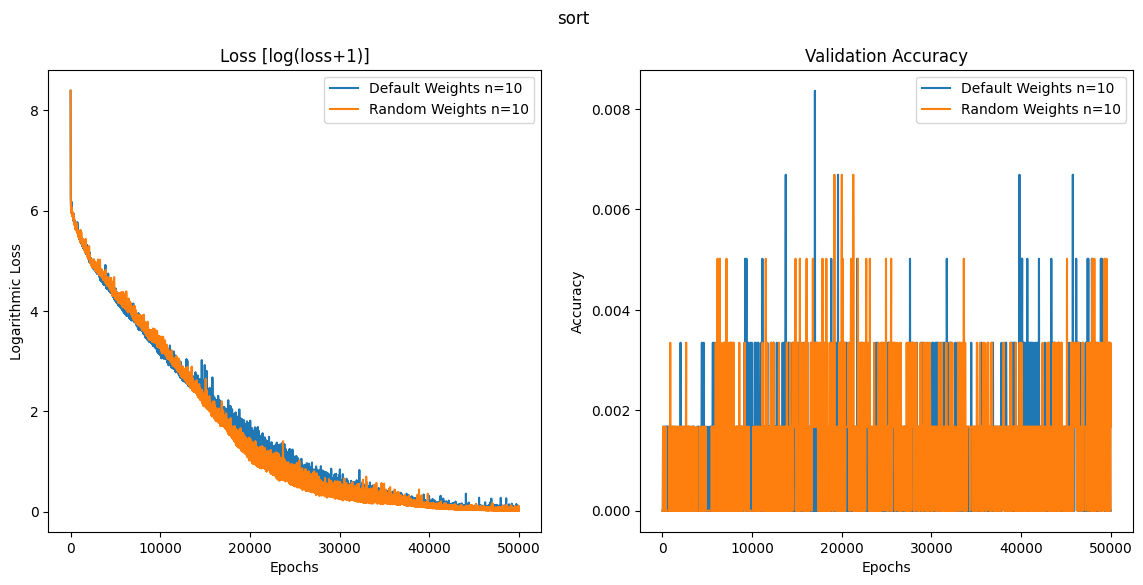

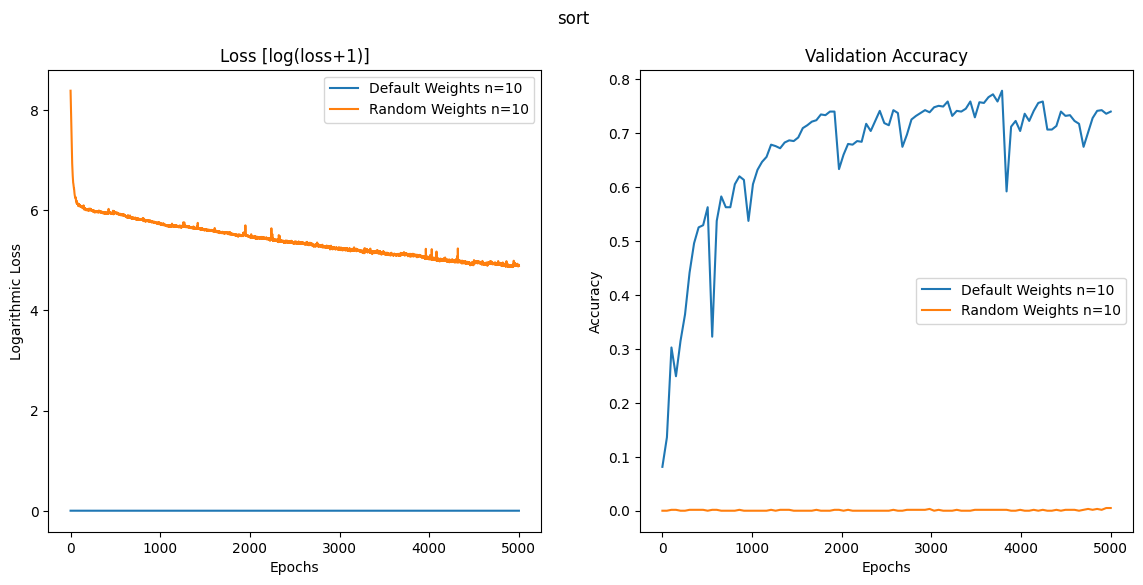

In [97]:
#Berzelius results
baseDirectory = os.path.abspath(os.path.join('../..')) + "/PerformanceTesting/savedData/finalOvertraining/overTraining/"
displayResults(baseDirectory, "sort", displayRandom=True, consideredVersions=[2])

#Local results
baseDirectory = "tempData/"
displayResults(baseDirectory, "sort", displayRandom=True, consideredVersions=[2], n_epochs=5000)